# Restart technique

Let's start by importing basic libraries

In [1]:
# Add the sibling folders
import sys, os
sys.path.insert(0, os.path.abspath('../..'))
from src.utils import *

import torch.optim as optim
import numpy as np
from sklearn import metrics

# Plot libraries and tables
from IPython.display import HTML, display
import tabulate
%matplotlib inline
import matplotlib.pyplot as plt
import mpld3
mpld3.enable_notebook()

import random as rm

import glob

## Estimating training loss with a sample of the trainingset

The approach that I'll be covering only uses a sample of minibatches to estimate the traing loss and accuracy.

The function for assessing the cost loops over all the minibatches and computes the cost. Here it is shown.

In [2]:
def test_train(trainloader, model):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    
    # All the batches are here looped
    for data in trainloader:
        images, labels = data
        outputs = model(Variable(images.cuda()))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()
        test_loss += float(F.cross_entropy(outputs, Variable(labels.cuda())).item())
        del images, labels, outputs

    return test_loss / total, correct / total

With the new function that I wrote, a number of (different) minibatches can be selected to estimate the value.


In [3]:
def test_train_sample(trainloader, model, n_minibatches=1):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    
    # Iterator over the minibatches
    trainiter = iter(trainloader)
    
    # Index 0 is added to ease the next loop but it is not used (unless selected in next operation)
    indexes = [0]

    # Sample the indexes
    indexes.append(random.sample(range(0, len(trainiter) - 2), n_minibatches)) # Last minibatch is left out
    
    # Order the indexes, in such a way the iterator is used only once
    indexes = sorted(indexes)
    
    for i in range(1, n_minibatches + 1):
        for j in range(indexes[i] - indexes[i - 1] - 1): # Go to next minibatch
            trainiter.next()

        images, labels = trainiter.next()

        outputs = model(Variable(images.cuda()))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        correct += (predicted == labels.cuda()).sum().item()
        test_loss += float(F.cross_entropy(outputs, Variable(labels.cuda())).item())
        del images, labels, outputs

    return test_loss / total, correct / total

Let's take a look now to the behaviour, comparing the two functions.

Results are loaded from a cluster computation. A basic SGD algorithm with momentum set to 0.9 has been used. A single minibatch is made out of 512 samples.

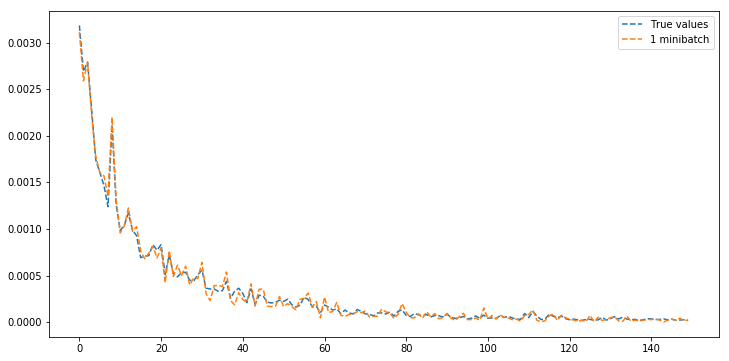

In [4]:
filename = '../../results/estimates'

results = np.load(f'{filename}.npz')

true_values = results['train_loss']
n_epochs = len(true_values)

estimated_values = results['train_loss_sample']

fix, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(0, n_epochs), true_values, '--', label='True values')
ax.plot(np.arange(0, n_epochs), estimated_values[0], '--', label='1 minibatch')

ax.legend()
plt.show()

Even one single minibatch seems to be effective.

Let's by increasing up to 10

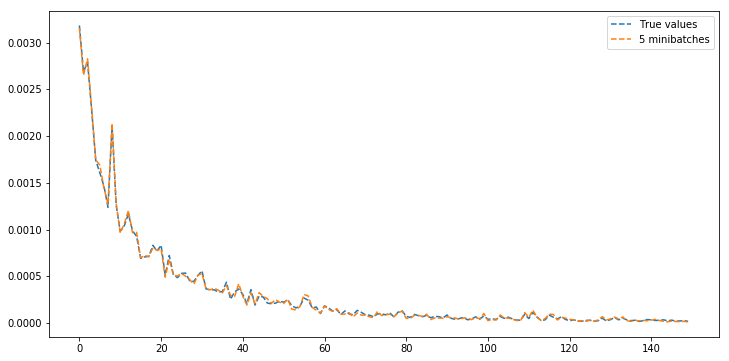

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(0, n_epochs), true_values, '--', label='True values')
ax.plot(np.arange(0, n_epochs), estimated_values[4], '--', label='5 minibatches')

ax.legend()
plt.show()

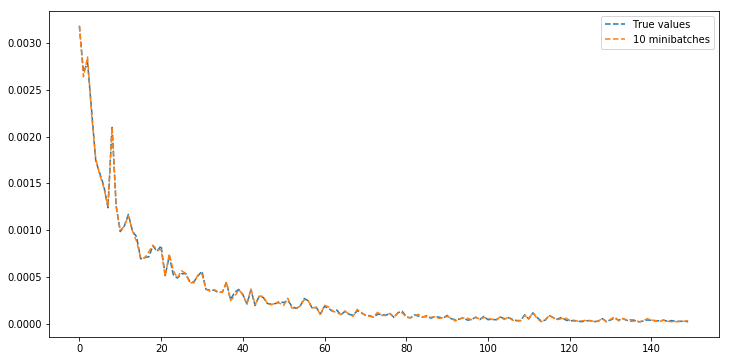

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(0, n_epochs), true_values, '--', label='True values')
ax.plot(np.arange(0, n_epochs), estimated_values[9], '--', label='10 minibatches')

ax.legend()
plt.show()

Mean absolute error can tell us more. 

10 minibatches, equivalent to 5120 images, seem to be a sufficient number to estimate the training loss.

In [7]:
errors = [['Number of minibatches', 'Mean Absolute Error']]

for i in range(10):
    errors.append([f"{i + 1}", metrics.mean_absolute_error(true_values, estimated_values[i])])

display(HTML(tabulate.tabulate(errors, tablefmt='html')))

Number of minibatches,Mean Absolute Error
1,3.382887586335613e-05
2,2.5235633445003385e-05
3,1.9348760920153775e-05
4,1.742864488109141e-05
5,1.5669643476324076e-05
6,1.6344706677129986e-05
7,1.4434029970297009e-05
8,1.4026305892620921e-05
9,1.0724562035988663e-05
10,1.0283127558215838e-05


## Comparison optimizers


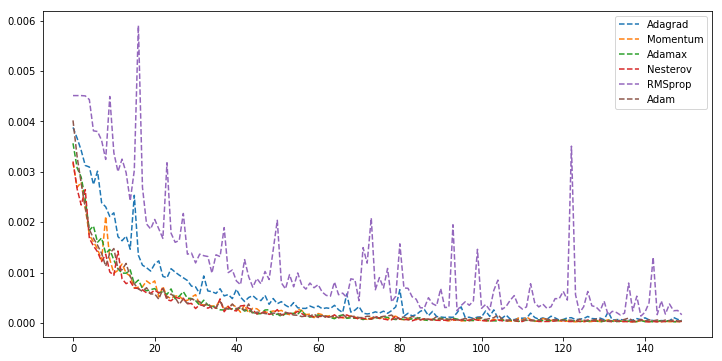

In [8]:
results = {}
for filename in glob.glob('../../results/optimizerComparison/*.npz'):
    filename_filtered = filename.split("/")[-1].split(".")[0]
    results.update({filename_filtered: np.load(filename)})

fig, ax = plt.subplots(figsize=(12, 6))

for name, result in results.items():
    
    n_epochs = len(result['train_loss'])
    ax.plot(np.arange(0, n_epochs), result['train_loss'], '--', label=name)
    
ax.legend()
plt.show()

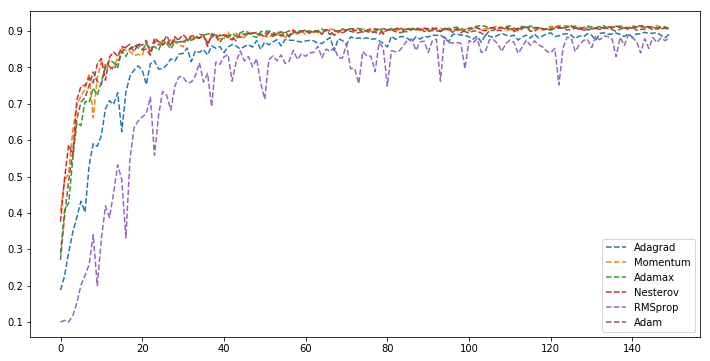

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

for name, result in results.items():
    
    n_epochs = len(result['validation_accuracy'])
    ax.plot(np.arange(0, n_epochs), result['validation_accuracy'], '--', label=name)
    
ax.legend()
plt.show()